In [234]:
from ddnn.nn import *
from ddnn.validation import *
from ddnn.data import *

estimator = Estimator(
    net=NeuralNetwork([
        LinearLayer((17, 4)),
        ActivationFunction("tanh"),
        LinearLayer((4, 1)),
        ActivationFunction("logistic")
    ]),
    loss=LossFunction("MSE"),
    # optimizer=Optimizer("SGD", learning_rate=1, momentum_coefficient=0.9, l2_coefficient=0),
    optimizer=Optimizer("Adam", learning_rate=1e-1, l2_coefficient=0),
    batchsize=-1,
    initializer=Initializer("glorot_uniform"),
)
early_stopping = None
epochs = 150
dataset_type = ("monk", 1)
# dataset_type = "ML_cup"
log_every = 1
losses = ["MSE", "binary_accuracy"]

In [235]:
if isinstance(dataset_type, tuple):
    traindata = read_monks(dataset_type[1], "train")
    traindata = onehot_encoding(data=traindata)

    testdata = read_monks(dataset_type[1], "test")
    testdata = onehot_encoding(data=testdata)
else:
    traindata, testdata = train_valid_split(read_ML_cup("train"), seed=123)

In [236]:
print(traindata.shape, testdata.shape)

(124, (17, 1)) (432, (17, 1))


In [237]:
testlogger = Logger(estimator, losses=losses, training_set=traindata, validation_set=testdata, every=log_every)
if early_stopping is not None:
    print("early stopping")
    teststopper = TrainingThresholdStopping(estimator, early_stopping)
    def callback(record):
        testlogger(record)
        teststopper(record)
else:
    def callback(record):
        testlogger(record)

In [238]:
estimator.train(traindata, callback=callback, n_epochs=epochs)

In [239]:
res = estimator.evaluate(losses=losses, dataset=traindata)
res

{'MSE': 0.0006017545515093659, 'binary_accuracy': 1.0}

In [240]:
res = estimator.evaluate(losses=losses, dataset=testdata)
res

{'MSE': 0.0009047257420432422, 'binary_accuracy': 1.0}

In [241]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ipywidgets import interact

interactive(children=(Dropdown(description='loss', options=('MSE', 'binary_accuracy'), value='MSE'), Output())…

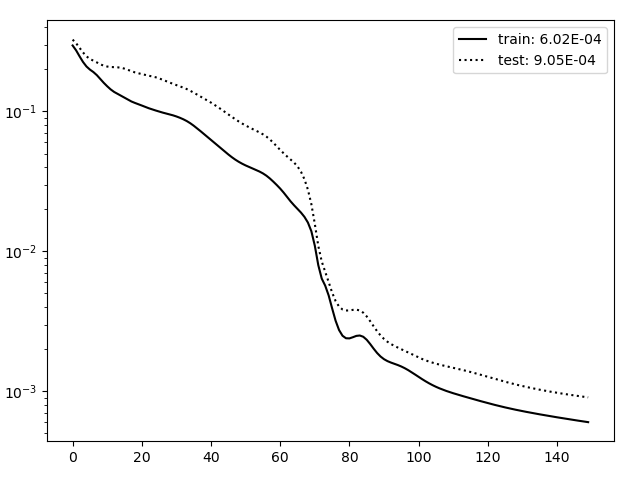

In [242]:
%matplotlib ipympl

# 1 plot with train and valid

fig, ax = plt.subplots()

@interact(
    loss = testlogger._losses,
)
def plot_results(loss):
    fig.tight_layout()
    ax.clear()
    for where, style in zip(["train", "valid"], [None, "dotted"]):
        y = testlogger._scores[0]["folds"][0][where][loss]
        if loss == "binary_accuracy":
            # todo fix to show last not best
            best = max(y)
            form = "{:.2}"
            logplot = False
        else:
            best = min(y)
            form = "{:.2E}"
            logplot = True
        # scale to resemble number of epochs instead of plot points
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*testlogger._every))
        ax.xaxis.set_major_formatter(ticks_x)
        if logplot:
            ax.set_yscale("log")
        else:
            ax.set_yscale("linear")
        if where == "valid":
            where = "test"
        ax.plot(y, label=f"{where}: {form.format(best)}", linestyle = style, color = "black")
        ax.legend()

In [243]:
n_tries = 30
train_loss_avg = {"MSE": 0, "binary_accuracy": 0}
test_loss_avg = {"MSE": 0, "binary_accuracy": 0}
for i in range(n_tries):
    estimator.reset()
    estimator.train(traindata, callback=lambda x: None, n_epochs=epochs)    
    train_res = estimator.evaluate(losses=losses, dataset=traindata)
    test_res = estimator.evaluate(losses=losses, dataset=testdata)
    print(train_res, test_res)
    for loss in losses:
        train_loss_avg[loss] += train_res[loss]
        test_loss_avg[loss] += test_res[loss]

for loss in losses:
    train_loss_avg[loss] = train_loss_avg[loss] / n_tries
    test_loss_avg[loss] = test_loss_avg[loss] / n_tries

{'MSE': 0.0005055686772001438, 'binary_accuracy': 1.0} {'MSE': 0.0007436708329532011, 'binary_accuracy': 1.0}
{'MSE': 0.0010779704370436148, 'binary_accuracy': 1.0} {'MSE': 0.001932921592703533, 'binary_accuracy': 1.0}
{'MSE': 0.0014988513823102785, 'binary_accuracy': 1.0} {'MSE': 0.04122447781720416, 'binary_accuracy': 0.9537037037037037}
{'MSE': 0.029638334946061093, 'binary_accuracy': 0.9758064516129032} {'MSE': 0.15067571873399152, 'binary_accuracy': 0.8240740740740741}
{'MSE': 0.000702078212991711, 'binary_accuracy': 1.0} {'MSE': 0.00619362758685035, 'binary_accuracy': 0.9953703703703703}
{'MSE': 0.05506292263682609, 'binary_accuracy': 0.9354838709677419} {'MSE': 0.07084125816019261, 'binary_accuracy': 0.9166666666666666}
{'MSE': 0.0005986196098344624, 'binary_accuracy': 1.0} {'MSE': 0.003884355503211582, 'binary_accuracy': 0.9953703703703703}
{'MSE': 0.03707573834096347, 'binary_accuracy': 0.9596774193548387} {'MSE': 0.07208683270042819, 'binary_accuracy': 0.9166666666666666}
{'M

In [244]:
print(train_loss_avg)
print(test_loss_avg)

{'MSE': 0.017338478080865593, 'binary_accuracy': 0.9819892473118278}
{'MSE': 0.03961420292979527, 'binary_accuracy': 0.9530092592592594}
